Импортирую библиотеки, соединяюсь с БД sql и загружаю Line magics для удобных sql запросов

In [1]:
%load_ext sql
import csv, sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from causalimpact import CausalImpact

con = sqlite3.connect("testcase.db")
%sql sqlite:///testcase.db

Смотрю на все, что есть в БД

In [2]:
%%sql
SELECT * FROM sqlite_master

 * sqlite:///testcase.db
Done.


type,name,tbl_name,rootpage,sql
table,source_comparison,source_comparison,2,"CREATE TABLE ""source_comparison"" (""Install_Dates"" TEXT, ""source_type"" TEXT, ""Country"" TEXT, ""installs"" REAL)"
table,costs,costs,132,"CREATE TABLE ""costs"" (""Install_Dates"" TEXT, ""campaign_id"" INTEGER, ""Country"" TEXT, ""installs"" REAL, ""spends"" REAL)"
table,revenue,revenue,218,"CREATE TABLE ""revenue"" (""Install_Dates"" TEXT, ""campaign_id"" INTEGER, ""Country"" TEXT, ""1d_LTV"" REAL, ""3d_LTV"" REAL, ""7d_LTV"" REAL, ""14d_LTV"" REAL, ""30d_LTV"" REAL, ""60d_LTV"" REAL)"


Загружаю нужный датасет в объект Pandas dataframe, переименовываю колонки, смотрю на вид датасета

In [3]:
src_comp = %sql SELECT * FROM source_comparison
source_comparison_df=src_comp.DataFrame()
source_comparison_df.info()

 * sqlite:///testcase.db
Done.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18606 entries, 0 to 18605
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Install_Dates  18606 non-null  object 
 1   source_type    18606 non-null  object 
 2   Country        18606 non-null  object 
 3   installs       18606 non-null  float64
dtypes: float64(1), object(3)
memory usage: 581.6+ KB


In [4]:
source_comparison_df.columns=['date', 'type', 'country', 'installs']
source_comparison_df.head()

,date,type,country,installs
0,2020-05-18,Paid,PY,4.0
1,2020-04-14,Paid,FR,35.0
2,2020-04-30,Paid,JP,25.0
3,2020-03-20,Paid,DE,11.0
4,2020-04-30,Paid,IT,8.0


Переделываю колонку date в временной формат данных и сортирую значения по времени

In [5]:
source_comparison_df.date=pd.to_datetime(source_comparison_df.date, format="%Y-%m-%d")
source_comparison_df.sort_values(by='date', inplace=True)
source_comparison_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18606 entries, 5216 to 0
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      18606 non-null  datetime64[ns]
 1   type      18606 non-null  object        
 2   country   18606 non-null  object        
 3   installs  18606 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 726.8+ KB


In [6]:
source_comparison_df.head()

,date,type,country,installs
5216,2020-03-18,Paid,BY,110.0
1286,2020-03-18,Organic,SD,11.0
17548,2020-03-18,Paid,BE,3.0
12248,2020-03-18,Organic,NL,36.0
12247,2020-03-18,Paid,TR,3.0


In [7]:
source_comparison_df.tail()

,date,type,country,installs
14578,2020-05-18,Organic,IR,25.0
14611,2020-05-18,Paid,US,2.0
14632,2020-05-18,Paid,BD,2.0
5383,2020-05-18,Paid,EC,16.0
0,2020-05-18,Paid,PY,4.0


Смотрю на даты, представленные в датасете.

In [8]:
source_comparison_df.date.unique()

<DatetimeArray>
['2020-03-18 00:00:00', '2020-03-19 00:00:00', '2020-03-20 00:00:00',
 '2020-03-21 00:00:00', '2020-03-22 00:00:00', '2020-03-23 00:00:00',
 '2020-03-24 00:00:00', '2020-03-25 00:00:00', '2020-03-26 00:00:00',
 '2020-03-27 00:00:00', '2020-03-28 00:00:00', '2020-03-29 00:00:00',
 '2020-03-30 00:00:00', '2020-04-01 00:00:00', '2020-04-02 00:00:00',
 '2020-04-03 00:00:00', '2020-04-04 00:00:00', '2020-04-05 00:00:00',
 '2020-04-06 00:00:00', '2020-04-07 00:00:00', '2020-04-08 00:00:00',
 '2020-04-09 00:00:00', '2020-04-10 00:00:00', '2020-04-11 00:00:00',
 '2020-04-12 00:00:00', '2020-04-13 00:00:00', '2020-04-14 00:00:00',
 '2020-04-15 00:00:00', '2020-04-16 00:00:00', '2020-04-17 00:00:00',
 '2020-04-18 00:00:00', '2020-04-19 00:00:00', '2020-04-20 00:00:00',
 '2020-04-21 00:00:00', '2020-04-22 00:00:00', '2020-04-23 00:00:00',
 '2020-04-24 00:00:00', '2020-04-25 00:00:00', '2020-04-26 00:00:00',
 '2020-04-27 00:00:00', '2020-04-28 00:00:00', '2020-04-29 00:00:00',
 '20

In [9]:
source_comparison_df[(source_comparison_df.country=='BY') & (source_comparison_df.type=='Paid')]

,date,type,country,installs
5216,2020-03-18,Paid,BY,110.0
7778,2020-03-18,Paid,BY,1.0
4399,2020-03-18,Paid,BY,22.0
11067,2020-03-19,Paid,BY,123.0
17132,2020-03-19,Paid,BY,27.0
...,...,...,...,...
15291,2020-05-17,Paid,BY,1.0
12477,2020-05-17,Paid,BY,1.0
9639,2020-05-17,Paid,BY,23.0
3480,2020-05-18,Paid,BY,234.0


Вижу, что в датасете для некоторых комбинаций значений даты, типа и страны есть несколько значений количества установок. Для этой задачи такое разбиение не нужно. 

С помощью группировки суммирую разные значения количества установок для одинаковых комбинаций значений даты, типа и страны. Сохраняю результат в новом датасете, с которым работаю дальше. В новом датасете каждая комбинация значений даты, типа и страны уникальна.

In [10]:
summed_df=source_comparison_df.groupby(by=['date', 'type', 'country']).installs.sum().to_frame().reset_index()

Добавляю новую колонку - неделя. Она используется только для столбчатой диаграммы, построенной ниже. 

In [11]:
summed_df['week']=summed_df.date.dt.isocalendar().week

In [12]:
summed_df

,date,type,country,installs,week
0,2020-03-18,Organic,AE,17.0,12
1,2020-03-18,Organic,AF,10.0,12
2,2020-03-18,Organic,AL,5.0,12
3,2020-03-18,Organic,AM,34.0,12
4,2020-03-18,Organic,AR,77.0,12
...,...,...,...,...,...
13025,2020-05-18,Paid,UY,6.0,21
13026,2020-05-18,Paid,UZ,35.0,21
13027,2020-05-18,Paid,VE,79.0,21
13028,2020-05-18,Paid,VN,36.0,21


Удостоверяюсь, что в датасете есть только два значения типа.

In [13]:
summed_df.type.unique()

array(['Organic', 'Paid'], dtype=object)

Для интереса построю парную столбчатую диаграмму суммарных значений количества загрузок для каждой недели.

Сохраняю суммы для каждой недели для разных типов в отдельные объекты.

In [14]:
paid_distr=summed_df[summed_df.type=='Paid'].groupby('week').installs.sum()
organic_distr=summed_df[summed_df.type=='Organic'].groupby('week').installs.sum()

Не для каждой недели в датасете представлено одинаковое число дней. Нормирую значения для каждой недели по количеству дней.

In [15]:
days_per_week=summed_df.groupby('week').date.nunique()
days_per_week

week
12    5
13    7
14    6
15    7
16    7
17    7
18    7
19    7
20    7
21    1
Name: date, dtype: int64

In [16]:
organic_distr=((organic_distr/days_per_week)*7).astype(int)
paid_distr=((paid_distr/days_per_week)*7).astype(int)

Строю столбчатую диаграмму. По ней видно, что есть смысл рассматривать гипотезу о том, что между видами загрузок может быть положительная зависимость. Например, с 14 на 15 и с 17 на 18 недели число "органических" загрузок растет вместе с числом "оплаченных".

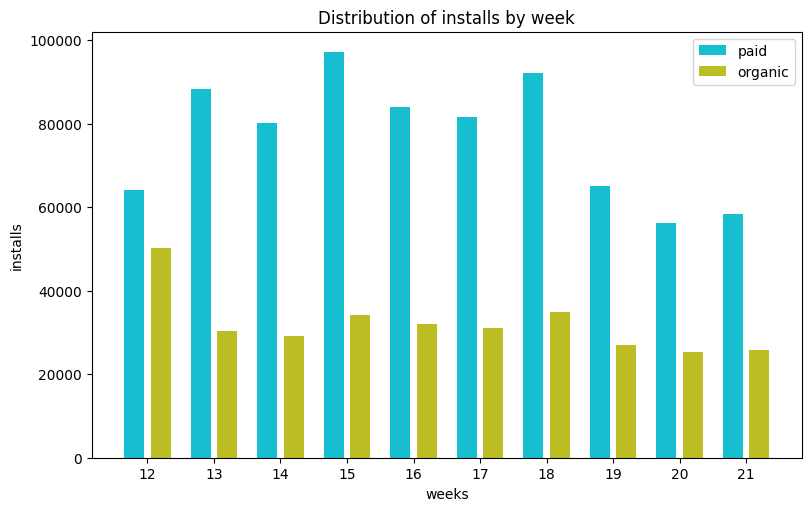

In [17]:
x=np.arange(len(paid_distr))

fig, ax = plt.subplots(figsize=(8,5), layout='constrained')
width=0.3
gap=0.1

ax.bar(x, paid_distr.values, width, label='paid', color='tab:cyan')
ax.bar(x + width + gap, organic_distr.values, width, label='organic', color='tab:olive')

ax.set_ylabel('installs')
ax.set_xticks(x + 0.5*(width+gap), organic_distr.index)
ax.set_xlabel('weeks')
ax.legend()
ax.set_title("Distribution of installs by week");

При анализе датасета мне стало понятно, что количество "оплаченных" загрузок изменяется по разному для каждой страны. Есть смысл проверить гипотезу на какой-нибудь одной стране, где число "оплаченных" загрузок увеличилось значительно.

Для каждой страны определяю число дней, для которых в датасете есть данные. Сохраняю результаты для разных типов загрузок в отдельных объектах. 

In [18]:
paid_countries=summed_df[(summed_df.type=='Paid')].groupby('country').date.nunique().sort_values()
organic_countries=summed_df[(summed_df.type=='Organic')].groupby('country').date.nunique().sort_values()

Общее число дней в датасете - 61. Выбираю только те страны, для которых есть данные по всем дням (чем больше данных - тем лучше модель). Всего таких стран 31.

In [19]:
many_values=set((paid_countries[paid_countries==61]).index)
many_values_org=set((organic_countries[organic_countries==61]).index)
first_day=set(summed_df[(summed_df.type=='Paid')&(summed_df.date=='2020-03-18')].country)
last_day=set(summed_df[(summed_df.type=='Paid')&(summed_df.date=='2020-05-18')].country)
selected_countries=list(many_values.intersection(first_day,last_day,many_values_org))
len(selected_countries)

31

С помощью преобразований выделяю данные по "оплаченным" установкам для найденных 31 страны в отдельные колонки.

In [20]:
plot_df=summed_df[(summed_df.type=='Paid')&(summed_df.country.isin(selected_countries))].pivot(index=['date'], columns='country', values='installs')

In [21]:
plot_df.head()

country,AT,BE,BR,BY,CA,CH,CZ,DE,DK,ES,...,NL,PH,PL,RO,RU,TW,UA,UK,US,UZ
date,,,,,,,,,,,,,,,,,,,,,
2020-03-18,5.0,4.0,183.0,133.0,34.0,11.0,18.0,130.0,4.0,30.0,...,2.0,77.0,9.0,42.0,4115.0,36.0,899.0,25.0,208.0,191.0
2020-03-19,6.0,1.0,186.0,151.0,19.0,4.0,24.0,132.0,4.0,19.0,...,5.0,47.0,4.0,44.0,3679.0,30.0,857.0,20.0,179.0,159.0
2020-03-20,10.0,6.0,162.0,123.0,7.0,13.0,21.0,136.0,4.0,20.0,...,3.0,45.0,5.0,45.0,4313.0,23.0,770.0,19.0,178.0,143.0
2020-03-21,14.0,21.0,644.0,113.0,15.0,17.0,42.0,191.0,12.0,28.0,...,5.0,47.0,10.0,39.0,5049.0,61.0,1236.0,33.0,406.0,148.0
2020-03-22,32.0,20.0,940.0,556.0,20.0,8.0,32.0,323.0,19.0,20.0,...,5.0,64.0,7.0,14.0,7581.0,126.0,1396.0,66.0,390.0,702.0


Строю новый датасет, показывающий относительные изменения значений в предыдущем датасете. Далее для каждой страны строю графики значений этого датасета с целью выбора страны, в которой значения "оплачиваемых" загрузок выросли значительно, и этот рост происходил примерно в середине, а не в начале или конце временного периода в датасете, чтобы у алгоритма Causal Impact Analysis было достаточно данных как для периода перед интервенцией, так и для периода после нее.

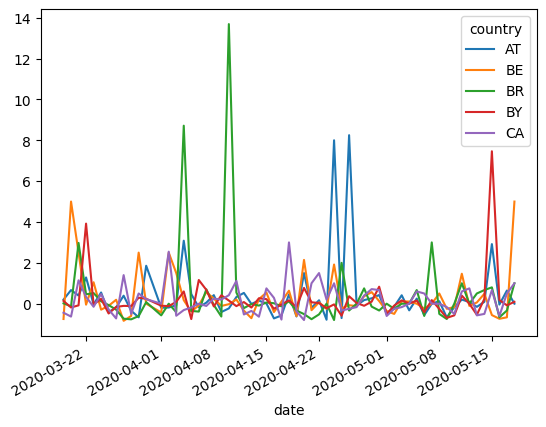

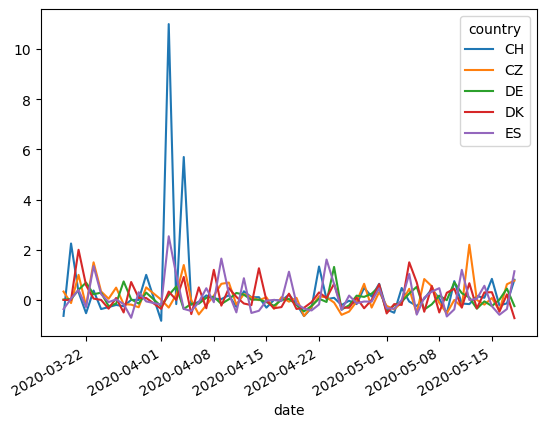

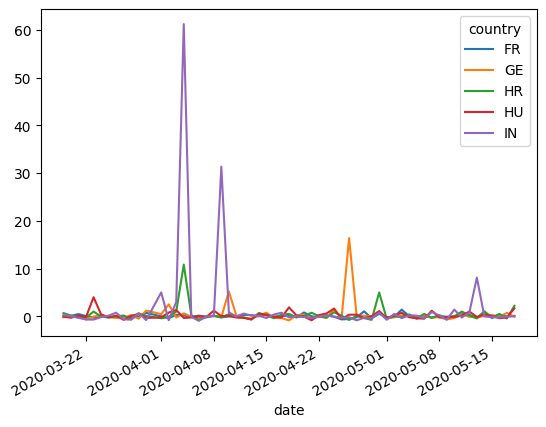

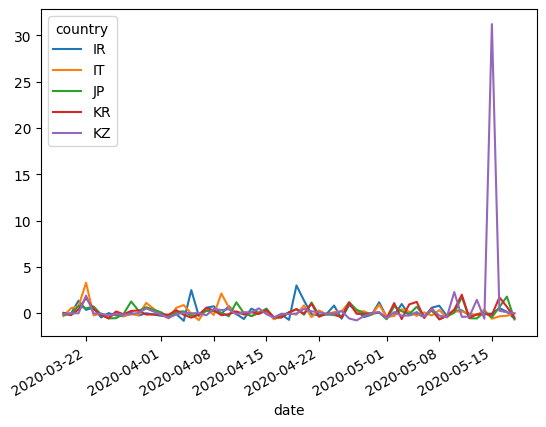

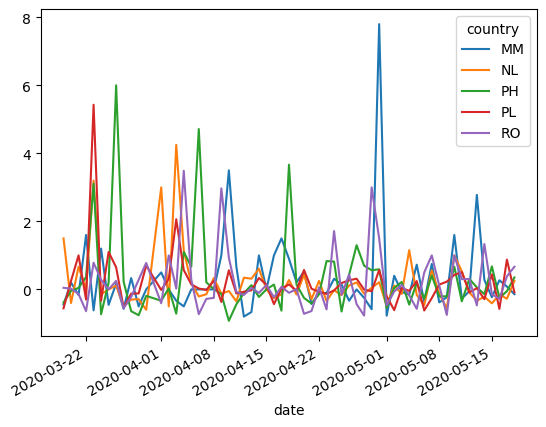

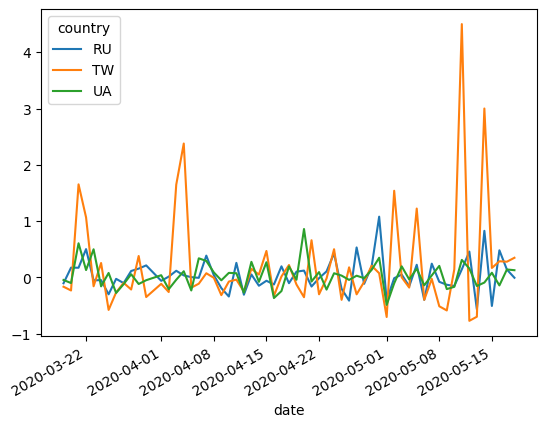

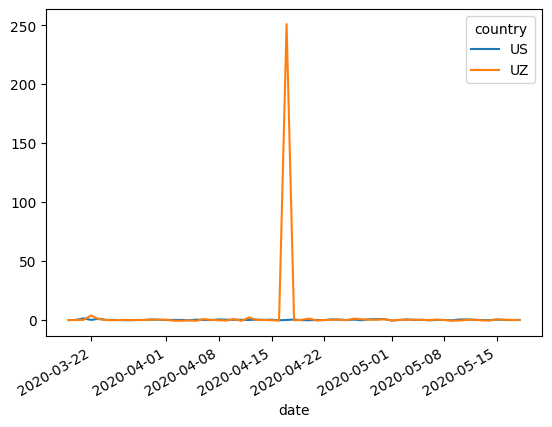

In [22]:
change_plot_df=plot_df.pct_change().iloc[1:]

for i in range(5):
    change_plot_df[change_plot_df.columns[i*5:(i+1)*5]].plot()
change_plot_df[change_plot_df.columns[25:28]].plot();
change_plot_df[change_plot_df.columns[29:]].plot();

Для анализа гипотезы выбираю страну IN. У этой страны есть большое увеличение "оплаченных" установок посередине временного периода.

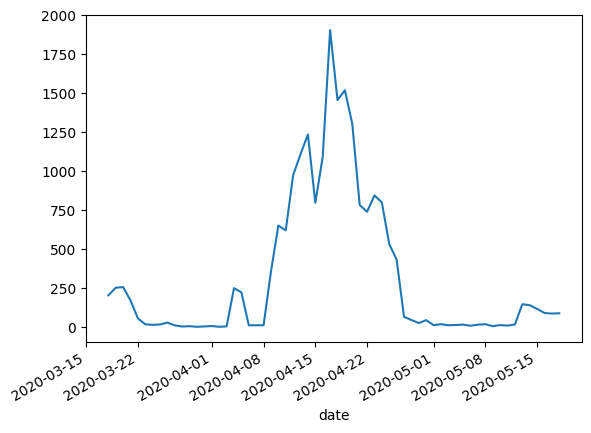

In [23]:
plot_df['IN'].plot();

Для алгоритма Causal Impact Analysis необходимо выбрать страну, в которой не было крупных увеличений оплаченных установок, и значения органических установок в период времени до начала увеличения числа оплаченных установок коррелировали со значениями органических установок в стране IN в этот период.

Выбираю все страны с низким максимальным показателем изменений числа оплаченных установок.

In [24]:
max_series=change_plot_df.max()
max_series

country
AT      8.250000
BE      5.000000
BR     13.687500
BY      7.461538
CA      3.000000
CH     11.000000
CZ      2.200000
DE      1.316456
DK      2.000000
ES      2.538462
FR      1.397059
GE     16.400000
HR     10.833333
HU      4.000000
IN     61.250000
IR      3.000000
IT      3.300000
JP      1.800000
KR      2.000000
KZ     31.222222
MM      7.800000
NL      4.250000
PH      6.000000
PL      5.428571
RO      3.487179
RU      1.078111
TW      4.500000
UA      0.858469
UK      1.692308
US      1.280899
UZ    251.000000
dtype: float64

In [25]:
unchanged_countries=list(max_series[max_series<=2].index)
unchanged_countries

['DE', 'DK', 'FR', 'JP', 'KR', 'RU', 'UA', 'UK', 'US']

Для каждой из этих стран рассчитываю коэффициент корреляции со значениями органических установок в стране IN в период до начала резкого увеличения оплаченных установок.

In [26]:
series_start='2020-03-23'
intervention_start='2020-04-09'
intervention_end='2020-04-27'
series_end='2020-05-13'
pearson_r_results=[]
organic_in=summed_df[(summed_df.type=='Organic')&
                     (summed_df.country=='IN')&
                     (summed_df.date>=series_start)&
                     (summed_df.date<intervention_start)].installs.values
for cntry in unchanged_countries:
    organic_other=summed_df[(summed_df.type=='Organic')&
                            (summed_df.country==cntry)&
                            (summed_df.date>=series_start)&
                            (summed_df.date<intervention_start)].installs.values
    pearson_r_results.append(pearsonr(organic_in, organic_other).pvalue)
most_correlated=pd.Series({cntry:pval for cntry,pval in zip(unchanged_countries, pearson_r_results)}).sort_values()
most_correlated

KR    0.055704
UA    0.115597
FR    0.203575
UK    0.304836
JP    0.391886
US    0.470209
DK    0.689087
RU    0.690379
DE    0.786477
dtype: float64

Выбираю страну с наименьшим Р-значением ('KR').

Строю график, показывающий значения органических установок в странах IN и KR в период до начала резкого увеличения оплаченных установок. Перед этим трансформирую значения методом минимакса (для каждой страны - отдельный трансформер).

In [27]:
organic_kr=summed_df[(summed_df.type=='Organic')&
                     (summed_df.country=='KR')&
                     (summed_df.date>=series_start)&
                     (summed_df.date<intervention_start)].installs.values

kr_scaler=MinMaxScaler()
in_scaler=MinMaxScaler()
organic_kr=kr_scaler.fit_transform(organic_kr.reshape(-1, 1)).reshape(-1)
organic_in=in_scaler.fit_transform(organic_in.reshape(-1, 1)).reshape(-1)

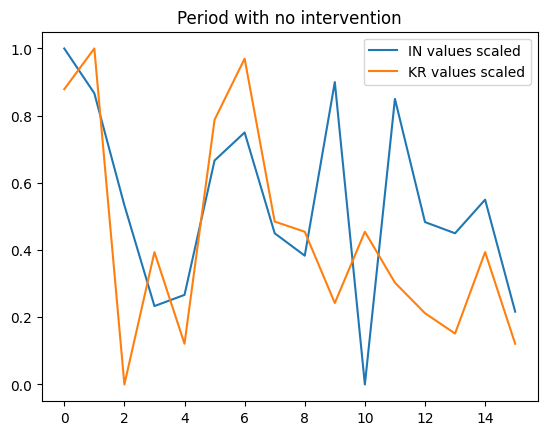

In [28]:
ax=plt.gca()
ax.plot(organic_in, label='IN values scaled')
ax.plot(organic_kr, label='KR values scaled')
ax.legend()
ax.set_title('Period with no intervention');

До начала изменений трансформированные значения для этих стран похожи друг на друга. Значит, их можно использовать для Causal Impact Analysis. 

Выделяю данные по органическим установкам в этих странах в отдельный объект.

In [29]:
testing_df=summed_df[(summed_df.type=='Organic')&
                     (summed_df.country.isin(['IN', 'KR']))&
                     (summed_df.date>=series_start)&
                     (summed_df.date<series_end)].pivot(index=['date'], columns='country', values='installs')

Для этого алгоритма данные должны быть с одинаковым шагом по времени ( в этом случае - календарный день).

In [30]:
testing_df=testing_df.asfreq('D')
testing_df

country,IN,KR
date,,
2020-03-23,114.0,45.0
2020-03-24,106.0,49.0
2020-03-25,86.0,16.0
2020-03-26,68.0,29.0
2020-03-27,70.0,20.0
2020-03-28,94.0,42.0
2020-03-29,99.0,48.0
2020-03-30,81.0,32.0
2020-03-31,NaN,NaN


В данных есть один пропущенный день. Заполняю его, используя среднее значений двух соседних дней.

In [31]:
testing_df.interpolate(axis=0, inplace=True)

Использую ранее полученные минимакс трансформеры для трансформации всего датасета (для Causal Impact Analysis в пайтоне нужно, чтобы до интервенции данные были близки по значению, а не просто коррелировали).

In [32]:
testing_df.IN=in_scaler.transform(testing_df.IN.values.reshape(-1, 1)).reshape(-1)
testing_df.KR=kr_scaler.transform(testing_df.KR.values.reshape(-1, 1)).reshape(-1)
testing_df.columns=['y','X']

Строю график трансформированных значений. Желтая линия показывает данные для страны KR, синяя - для страны IN, красная вертикальная линия - день начала интервенции, желтая вертикальная линия - день конца интервенции

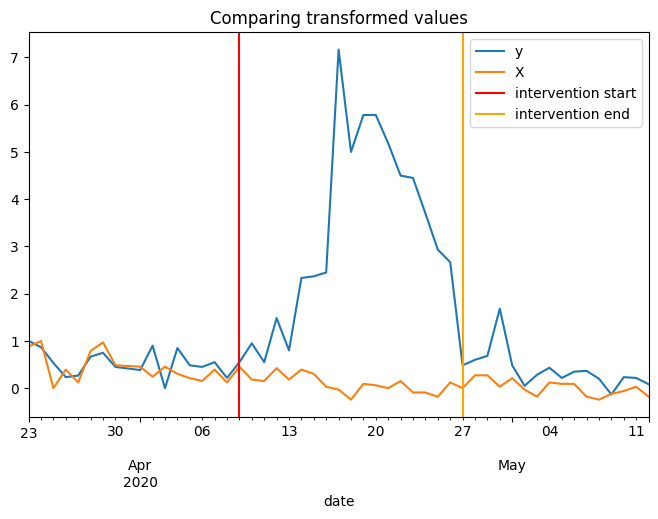

In [33]:
fig, ax=plt.subplots(figsize=(8,5))
testing_df.plot(ax=ax)
plt.axvline(intervention_start, color='red', label='intervention start')
plt.axvline(intervention_end, color='orange', label='intervention end')
ax.legend()
ax.set_title('Comparing transformed values');

Запускаю Causal Impact Analysis. Гипотеза маркетологов говорит о том, что рост рекламного траффика ведет к росту органического. Нулевая гипотеза утверждает, что рост рекламного траффика не ведет к росту органического. Устанавливаю порог Р-значения в 0,05 для того, чтобы отвергнуть нулевую гипотезу.  

In [34]:
pre_period=[series_start,'2020-04-08']
post_period=[intervention_end, '2020-05-12']

In [35]:
impact=CausalImpact(data=testing_df, pre_period=pre_period, post_period=post_period)

C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


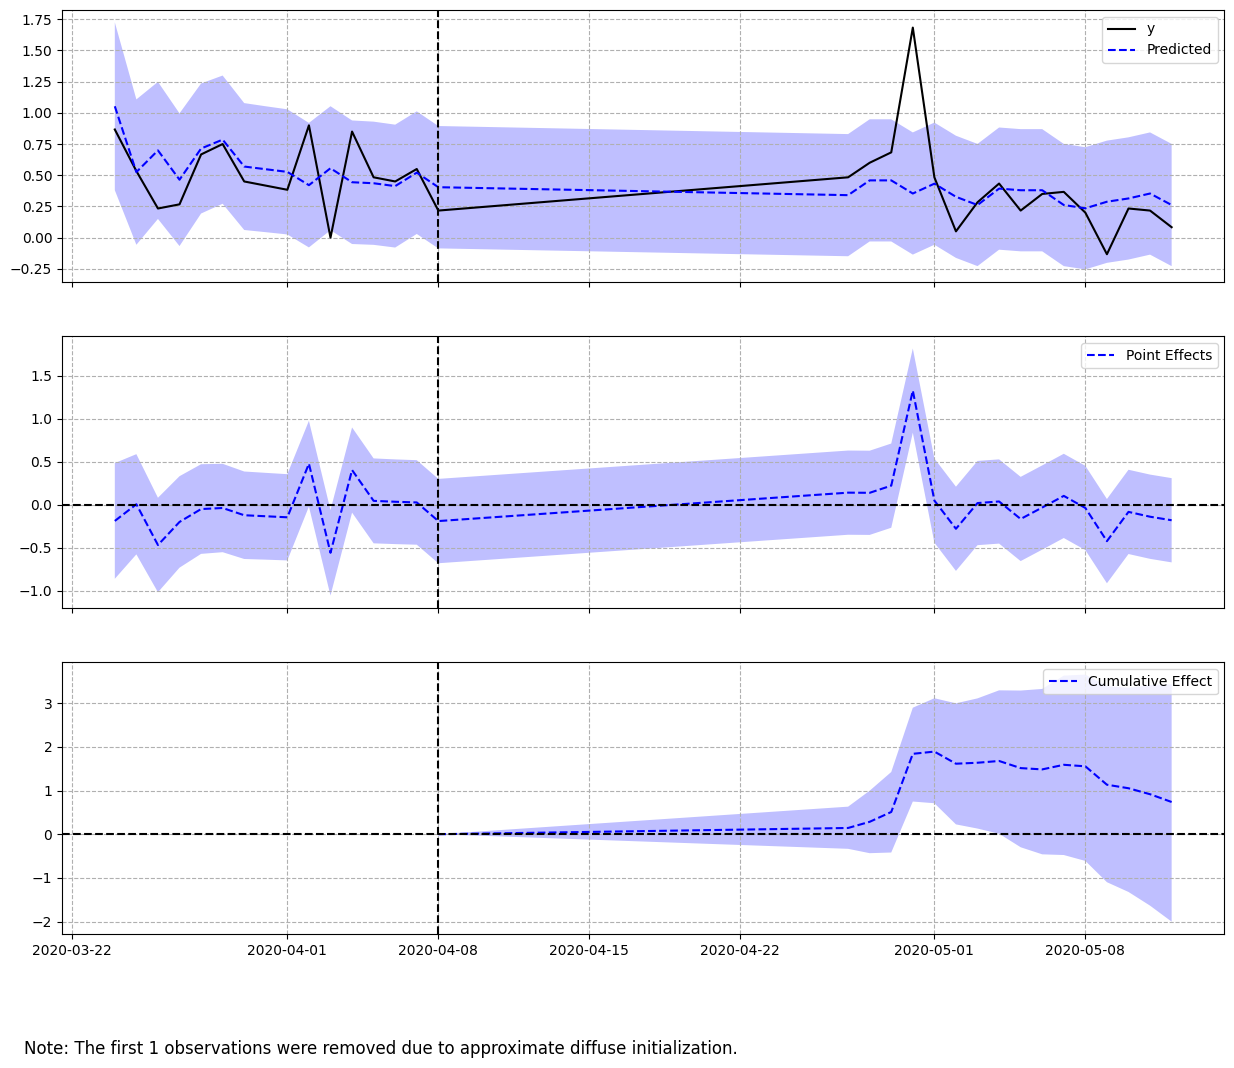

In [36]:
impact.plot()

In [37]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.39               6.23
Prediction (s.d.)         0.34 (0.09)        5.5 (1.38)
95% CI                    [0.18, 0.51]       [2.81, 8.23]

Absolute effect (s.d.)    0.05 (0.09)        0.74 (1.38)
95% CI                    [-0.12, 0.21]      [-2.0, 3.43]

Relative effect (s.d.)    13.41% (25.19%)    13.41% (25.19%)
95% CI                    [-36.37%, 62.36%]  [-36.37%, 62.36%]

Posterior tail-area probability p: 0.28
Posterior prob. of a causal effect: 71.93%

For more details run the command: print(impact.summary('report'))


В итоге получаю, что Р-значение равно 0,28. Значит, нулевая гипотеза не отвергнута, т.е. гипотеза маркетологов не подтверждена. При этом вероятность того, что она верна, равна 71,93%.